
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.


In [4]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")


# Preparing the dataset

In [5]:
# loading the dataset
dataset = VBAIDataset('./../data/bids_with_sensitive_recordings/')
#dataset_sample = VBAIDataset('./data/sample_data/')

target_diagnosis = 'voc_fold_paralysis' #airway_stenosis


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [6]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)
'''
train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])
'''

import random
from sklearn.model_selection import train_test_split

train_identities, DT_test_identities = train_test_split(all_identities, test_size=0.15, random_state=123)
val_identities, test_identities = train_test_split(DT_test_identities, test_size=0.5, random_state=123)

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))


train: 151
val: 13
test: 14


### Create PyTorch dataset of all audio features given in the .pt file

In [7]:

qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))


Found 204 person/session pairs


In [8]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
print(sorted(list(participant_df.columns)))
#diagnosis_data = participant_df[['record_id', self.diagnosis_column]].to_numpy()

['add_adhd', 'age', 'airway_stenosis', 'alcohol_subst_abuse', 'als', 'alz_dementia_mci', 'asd', 'asthma', 'benign_cord_lesion', 'bipolar', 'bpd', 'chronic_cough', 'copd', 'depression', 'diagnois_bl_gsd', 'diagnois_lc_gsd_sll', 'diagnois_pl_gsd_bp', 'diagnois_pl_gsd_ls', 'diagnosis_als_cp___bulbar_symptoms', 'diagnosis_als_cp___lower_motor_neuron', 'diagnosis_als_cp___respiratory_involvement', 'diagnosis_als_cp___upper_motor_neuron', 'diagnosis_als_disease_subtype', 'diagnosis_als_disease_subtype_familial', 'diagnosis_als_dp', 'diagnosis_als_etiology___environmental_factors', 'diagnosis_als_etiology___genetic_factors', 'diagnosis_als_etiology_genetic_factors___c9orf72', 'diagnosis_als_etiology_genetic_factors___other', 'diagnosis_als_etiology_genetic_factors___sod1', 'diagnosis_als_gsd_calculation', 'diagnosis_als_gsd_category_1', 'diagnosis_als_gsd_category_2', 'diagnosis_als_gsd_category_3', 'diagnosis_als_na_alsfrs_r_score', 'diagnosis_als_na_fvc_percentage', 'diagnosis_als_treatment

In [9]:

import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")


class MyAudioDataset(torch.utils.data.Dataset):
    def __init__(self, identities, dataset, person_session_pairs, diagnosis_column = 'voc_fold_paralysis', segment_size=3):
        
        self.segment_size = segment_size
        self.diagnosis_column = diagnosis_column
        
        # Define gender mapping
        self.gender_mapping = {
            'Male gender identity': 0,
            'Female gender identity': 1,
            'no record': 2,
            'Non-binary or genderqueer gender identity': 3
        }
        self.reverse_gender_mapping = {v: k for k, v in self.gender_mapping.items()}

        self.site_mapping = {
            'Mt. Sinai': 0, 
            'VUMC': 1,
            'MIT': 2,
            'USF': 3,
            'WCM': 4
        }

        # Define bins for age ranges and labels
        self.bins = [0, 20, 40, 60, 80, 100]
        self.labels = [0, 1, 2, 3, 4]

        self.reverse_site_mapping = {v: k for k, v in self.site_mapping.items()}
        
        # get age and airway stenosis classification for all subjects
        participant_df = dataset.load_and_pivot_questionnaire('participant')
        demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')
        
        age_data = participant_df[['record_id', 'age']].to_numpy()
        site_data = participant_df[['record_id', 'enrollment_institution']].to_numpy()
        
        gender_df = demographics_df[['record_id', 'gender_identity']]
        no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']
        new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})
        
        gender_data = pd.concat([gender_df, new_row_df], ignore_index=True).to_numpy()

        diagnosis_data = participant_df[['record_id', self.diagnosis_column]].to_numpy()
        
        age_dict = {}
        binned_age_dict = {}
        for person_id, age in age_data:
            binned_age = np.digitize(float(age), self.bins, right=True) - 1
            age_dict[str(person_id)] = float(age)
            binned_age_dict[str(person_id)] = self.labels[binned_age]

        gender_dict = {}
        for person_id, gender in gender_data:
            gender_dict[str(person_id)] = self.gender_mapping.get(str(gender), -1)  # Default to -1 if not found
        
        site_dict = {}
        for person_id, site in site_data:
            site_dict[str(person_id)] = self.site_mapping.get(str(site), -1)  # Default to -1 if not found

        diagnosis_dict = {}
        for person_id, dgnsis in diagnosis_data:
            diagnosis_dict[str(person_id)] = float(dgnsis)
        
        self.feature_files = []
        self.age = []
        self.binned_age = []
        self.gender = []
        self.site = []
        self.diagnosis = []
        
        for person_id, session_id in person_session_pairs:
            if person_id not in identities:
                continue
            
            audio_features = [str(path) for path in dataset.find_audio_features(person_id, session_id) if "Audio-Check" not in str(path)]
            self.feature_files += audio_features
            self.age += [age_dict[person_id]]*len(audio_features)
            self.binned_age += [binned_age_dict[person_id]]*len(audio_features)
            self.gender += [gender_dict[person_id]]*len(audio_features)
            self.site += [site_dict[person_id]]*len(audio_features)
            self.diagnosis += [diagnosis_dict[person_id]]*len(audio_features)
        
        assert len(self.feature_files) == len(self.age) == len(self.gender) == len(self.site) == len(self.diagnosis)
        
    def __len__(self):
        return len(self.feature_files)
    
    def map_gender_back(self, gender_numeric):
        return self.reverse_gender_mapping.get(gender_numeric, 'unknown')
        
    def map_site_back(self, site_numeric):
        return self.reverse_site_mapping.get(site_numeric, 'unknown')
        
    def __getitem__(self, idx):
        feature = torch.load(self.feature_files[idx])
        #opensmile_feature = feature['opensmile']
        age = self.age[idx]
        gender = self.gender[idx]
        site = self.site[idx]
        binned_age = self.binned_age[idx]
        diagnosis = self.diagnosis[idx]
        
        return feature, age, gender, site, binned_age, diagnosis

In [10]:
train_dataset = MyAudioDataset(train_identities, dataset, person_session_pairs)
val_dataset = MyAudioDataset(val_identities, dataset, person_session_pairs)
test_dataset = MyAudioDataset(test_identities, dataset, person_session_pairs)
DT_test_dataset = MyAudioDataset(DT_test_identities, dataset, person_session_pairs)

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs)

print("Train data size : " , len(train_dataset))
print("Validation data size : ", len(val_dataset))
print("Test data size : ", len(test_dataset))
print("-----------------------")
print("Test set for Decision Tree Algo : ", len(DT_test_dataset))
print("Lenght of full dataset : " , len(full_dataset))


Train data size :  5160
Validation data size :  410
Test data size :  449
-----------------------
Test set for Decision Tree Algo :  859
Lenght of full dataset :  6019


In [11]:
#participant_df = dataset.load_and_pivot_questionnaire('participant')

#print(sorted(list(participant_df.columns)))

print(train_dataset.diagnosis.count(1.0))
print(val_dataset.diagnosis.count(1.0))
print(test_dataset.diagnosis.count(1.0))

920
66
68


### Preparing the data for the visualization and Decision Tree based functions

In [12]:
def create_open_smile_df(audio_dataset, include_GAS = True, diagnosis_column = 'voc_fold_paralysis'):
    # Extract opensmile features, age, gender, and site
    opensmile_features = []
    ages = []
    genders = []
    sites = []
    GENDERS_org = []
    SITES_org = []
    AGE_binned = []
    diagnosis = []

    for i in range(len(audio_dataset)):
        feature, age, gender, site, binned_age, diagnosis_label = audio_dataset[i]
        opensmile_feature = feature['opensmile']
        opensmile_features.append(opensmile_feature.squeeze())
        ages.append(age)
        genders.append(gender)
        sites.append(site)
        GENDERS_org.append(audio_dataset.map_gender_back(gender))
        SITES_org.append(audio_dataset.map_site_back(site))
        AGE_binned.append(binned_age)
        diagnosis.append(diagnosis_label)
    
    # Convert to DataFrame
    opensmile_df = pd.DataFrame(opensmile_features)
    opensmile_df['age'] = ages
    opensmile_df['gender'] = genders
    opensmile_df['site'] = sites
    opensmile_df['GENDER_org'] = GENDERS_org
    opensmile_df['SITE_org'] = SITES_org
    opensmile_df['AGE_bin'] = AGE_binned
    opensmile_df[diagnosis_column] = diagnosis
    
    
    # Standardize the opensmile features
    if include_GAS:
        feature_columns = opensmile_df.columns[:-4]
        label_columns = opensmile_df.columns[-4:]
    
    else:
        feature_columns = opensmile_df.columns[:-7]
        label_columns = opensmile_df.columns[-7:]
    
    return opensmile_df, feature_columns, label_columns

# Now let's do decision tree based classifier!!!

## Defining Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

def RF_classifier(train_dataset, include_GAS = True, target_column = 'voc_fold_paralysis'):
    
    opensmile_df_train, feature_columns_train , _ = create_open_smile_df(train_dataset, include_GAS=include_GAS,
                                                                         diagnosis_column = target_column)

    scalar = StandardScaler()
    X_train = scalar.fit_transform(opensmile_df_train[feature_columns_train])
    y_train = opensmile_df_train[target_column] 
    
    #Train a RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    return clf, scalar


## Including Gender, Age, Site as feature

In [14]:
# age, gender, site, vocal_fold_paralysis
target_diagnosis = 'voc_fold_paralysis'
RF_clf, scalar = RF_classifier(train_dataset, include_GAS=True, target_column = target_diagnosis)

# Creating test data for generating prediction using RF classifier.
# An training_dataset instance needs to be passed so that the same transformations are used.

opensmile_df_test, feature_columns , label_columns = create_open_smile_df(DT_test_dataset,include_GAS=True,
                                                                          diagnosis_column = target_diagnosis)
X_test = scalar.transform(opensmile_df_test[feature_columns])
y_test = opensmile_df_test[target_diagnosis]
predictions = RF_clf.predict(X_test)

print(label_columns)

Index(['GENDER_org', 'SITE_org', 'AGE_bin', 'voc_fold_paralysis'], dtype='object')


### Feature importance (including GAS)

In [15]:
# Get feature importances
feature_importances = RF_clf.feature_importances_
#print(feature_importances.shape)
#print(len(feature_columns))
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                          Feature  Importance
90                                           site    0.085062
88                                            age    0.048084
26                               mfcc3_sma3_amean    0.017653
24                               mfcc2_sma3_amean    0.017045
12                   loudness_sma3_percentile20.0    0.016773
..                                            ...         ...
6     F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope    0.005255
83                     MeanVoicedSegmentLengthSec    0.005226
7   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope    0.005208
84                   StddevVoicedSegmentLengthSec    0.005173
89                                         gender    0.003265

[91 rows x 2 columns]


### Different Fairness Metrics

In [16]:

# https://towardsdatascience.com/mitigating-bias-in-ai-with-aif360-b4305d1f88a9
# https://aif360.readthedocs.io/en/stable/modules/generated/aif360.sklearn.metrics.disparate_impact_ratio.html

from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from fairness import tools, balancers

_gender_mapping_ = {
    'Male gender identity': 0,
    'Female gender identity': 1,
    'no record': 2,
    'Non-binary or genderqueer gender identity': 3
}

_site_mapping_ = {
    'Mt. Sinai': 0, 
    'VUMC': 1,
    'MIT': 2,
    'USF': 3,
    'WCM': 4
}

_age_mapping_ = {
    '0-20': 0,
    '21-40': 1,
    '41-60': 2,
    '61-80': 3,
    '81-100': 4
}

def chi_DIR_plot(dataset, _opensmile_df_, ground_truth, _predictions_, attribute='gender', calc_chi_square=True):
    
    #print("---" , attribute.upper(), "---")
    
    sensitive_attribute = _opensmile_df_[attribute]
    if attribute == 'age':
        sensitive_attribute = _opensmile_df_['AGE_bin']
        
    contingency_table = pd.crosstab(sensitive_attribute, _predictions_, rownames=[attribute], colnames=['Prediction'])
    
    # Compare distributions
    _print_string_ = f'---{attribute.upper()}---\n'
    if calc_chi_square:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi_square_result = {
            "chi2_stat": chi2_stat,
            "p_value": p_value,
            "dof": dof,
            "expected": expected
        }
        #print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')
        _print_string_ += f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n'

    unique_groups = sensitive_attribute.unique()
    favorable_outcome = {}

    def age_map(x):
        labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
        return labels[x]

    if attribute == 'gender':
        map_func = dataset.map_gender_back
    elif attribute == 'site':
        map_func = dataset.map_site_back
    elif attribute == 'age':
        map_func = age_map
        
    accuracies = [_predictions_ == ground_truth]
    for group in unique_groups:
        #group_predictions = _predictions_[sensitive_attribute == group]
        group_predictions = accuracies[0][sensitive_attribute == group]
        group_truth = ground_truth[sensitive_attribute == group]
        
        favorable_outcome[group] = np.mean(group_predictions)
        
    most_favorable_group = max(favorable_outcome, key=favorable_outcome.get)
    disparate_impact_ratios = {group: favorable_outcome[group] / favorable_outcome[most_favorable_group] for group in unique_groups}
    
    #Print the disparate impact ratios
    for group, ratio in disparate_impact_ratios.items():
        _print_string_ += f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}\n'
        #print(f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}')

    # Plotting the disparate impact ratios
    plt.figure(figsize=(10, 6))
    groups = [map_func(group) for group in unique_groups]
    ratios = [disparate_impact_ratios[group] for group in unique_groups]
    plt.bar(groups, ratios, color=plt.get_cmap('tab10').colors[:len(unique_groups)])
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
    plt.xlabel('Groups')
    plt.ylabel('Disparate Impact Ratio')
    plt.title('Disparate Impact Ratios by Group')
    plt.legend()
    plt.show()

    return chi_square_result, disparate_impact_ratios, _print_string_

# Scott Lee, “scotthlee/fairness: First release!”. Zenodo, Jun. 01, 2021. doi: 10.5281/zenodo.4890946.
# https://github.com/scotthlee/fairness/tree/master?tab=readme-ov-file

# https://developers.google.com/machine-learning/glossary/fairness#s
# https://pubs.rsna.org/page/ai/blog/2023/08/ryai_editorsblog082523

# https://github.com/gpleiss/equalized_odds_and_calibration

# def reload_fairness_modules():
#     importlib.reload(tools)
#     importlib.reload(balancers)

def equalized_metrics(_opensmile_df_, y_gt, y_pred, attribute='gender'):
    #reload_fairness_modules()
    print("---" , attribute.upper(), "---")
    sensitive_attribute = _opensmile_df_[attribute]
    pred_stats = tools.clf_metrics(y_gt, y_pred)
    print(pred_stats)
    
    pb = balancers.BinaryBalancer(y=y_gt, y_=y_pred, a=sensitive_attribute, summary=False)
    print("\nEqualized ODDs")
    pb.adjust(goal='odds', summary=False)
    pb.summary()
    #pb.plot(xlim=(0, 0), ylim=(0, 0), lp_lines=False, roc_curves=False)

    print("Equal Opportunity")
    pb.adjust(goal='opportunity', summary=False)
    pb.summary()
    #pb.plot(xlim=(0, 0), ylim=(0, 0), lp_lines=False, roc_curves=False)


#### Gender fairness

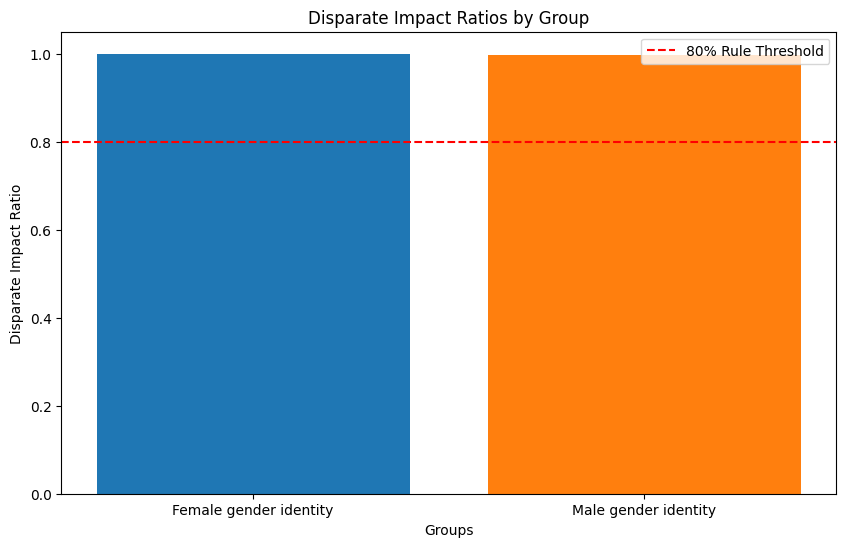

---GENDER---
Chi-Square Statistic: 5.690881268845854, p-value: 0.017053288504899886
Disparate Impact Ratio for Group Female gender identity: 1.0
Disparate Impact Ratio for Group Male gender identity: 0.9969860548807916


--- GENDER ---
     tp   fp     tn     fn   sens    spec     ppv     npv       j      f1  \
0  13.0  3.0  722.0  121.0  0.097  0.9959  0.8125  0.8565  0.0929  0.1733   

        mcc   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.249262  0.1444  0.0  0.0      134.0       16.0     -118.0        -0.8806  

Equalized ODDs

Pre-adjustment group rates are 

 group   fpr    tpr
   0.0 0.000 0.0000
   1.0 0.006 0.1354

And loss is 0.1444


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1560

Equal Opportunity

Pre-adjustment group rates are 

 group   fpr    tpr
   0.0 0.000 0.0000
   1.0 0.006 0.1354

And loss is 0.1444


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0

In [17]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='gender')
print()

#### Age fairness

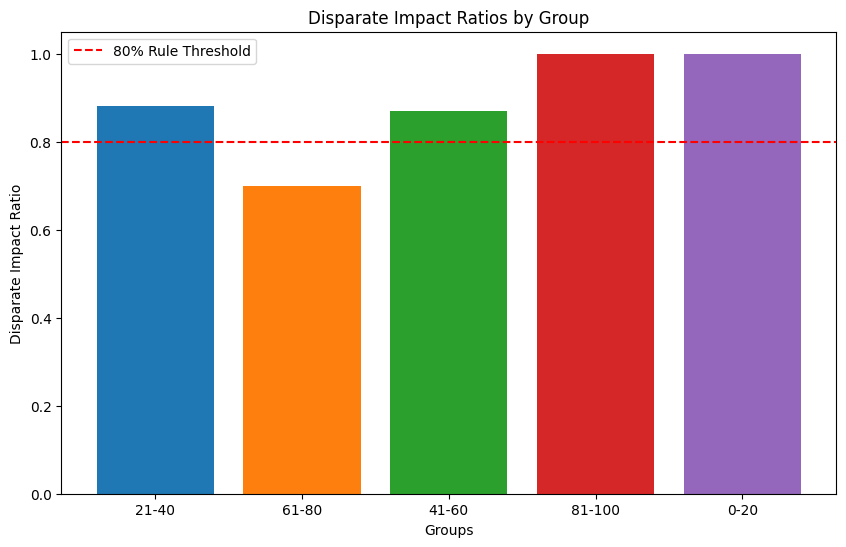

---AGE---
Chi-Square Statistic: 12.944197229847974, p-value: 0.011551699428678673
Disparate Impact Ratio for Group 21-40: 0.8809523809523809
Disparate Impact Ratio for Group 61-80: 0.6984924623115578
Disparate Impact Ratio for Group 41-60: 0.8697068403908795
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 0-20: 1.0


--- AGE_BIN ---
    tp   fp     tn     fn    sens    spec   ppv     npv      j      f1  \
0  6.0  2.0  723.0  128.0  0.0448  0.9972  0.75  0.8496  0.042  0.0845   

        mcc   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.158724  0.1513  0.0  0.0      134.0        8.0     -126.0        -0.9403  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0000    NaN
   1.0 0.0000 0.0000
   2.0 0.0074 0.0000
   3.0 0.0000 0.0909
   4.0 0.0000    NaN

And loss is 0.1513


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  0.0
   3.0  0.0  0.0
   4.0  0

In [15]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='age')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='AGE_bin')
print()

#### Site fairness

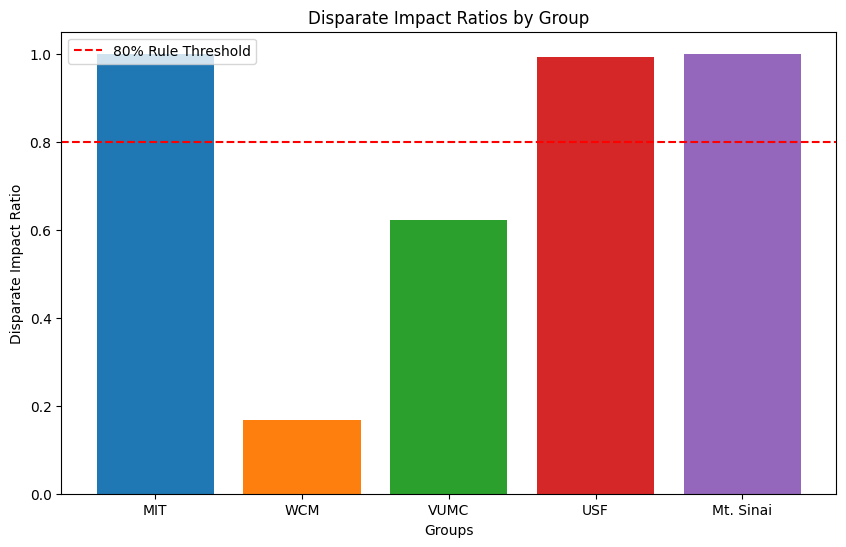

---SITE---
Chi-Square Statistic: 101.86309328262342, p-value: 3.9458593061832665e-21
Disparate Impact Ratio for Group MIT: 1.0
Disparate Impact Ratio for Group WCM: 0.16666666666666666
Disparate Impact Ratio for Group VUMC: 0.6230769230769231
Disparate Impact Ratio for Group USF: 0.992831541218638
Disparate Impact Ratio for Group Mt. Sinai: 1.0


--- SITE ---
    tp   fp     tn     fn    sens    spec   ppv     npv      j      f1  \
0  6.0  2.0  723.0  128.0  0.0448  0.9972  0.75  0.8496  0.042  0.0845   

        mcc   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.158724  0.1513  0.0  0.0      134.0        8.0     -126.0        -0.9403  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0000    NaN
   1.0 0.0000 0.0000
   2.0 0.0000    NaN
   3.0 0.0072    NaN
   4.0    NaN 0.1667

And loss is 0.1513


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  NaN
   3.0  0.0  NaN
   4.0  NaN 

In [16]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='site')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='site')
print()

# Now let's do decision tree based classifier!!!
## W/o Including Gender, Age, Site as feature

In [17]:
#train_dataset = MyAudioDataset(train_identities, dataset, person_session_pairs)
#train_dataset.scaler = None
#opensmile_df, scaled_features, feature_columns, label_columns = create_open_smile_df(train_dataset, include_GAS=False)
RF_clf, scalar = RF_classifier(train_dataset, include_GAS=False, target_column=target_diagnosis)
#Creating test data for generating prediction using RF classifier
opensmile_df_test, feature_columns , label_columns = create_open_smile_df(DT_test_dataset,include_GAS=False,
                                                                          diagnosis_column = target_diagnosis)

#print(scaled_features_test.shape)
X_test = scalar.transform(opensmile_df_test[feature_columns])
y_test = opensmile_df_test[target_diagnosis]
predictions = RF_clf.predict(X_test)
print(label_columns)


Index(['age', 'gender', 'site', 'GENDER_org', 'SITE_org', 'AGE_bin',
       'voc_fold_paralysis'],
      dtype='object')


### Feature importance (w/o including GAS)

In [18]:
# Get feature importances
feature_importances = RF_clf.feature_importances_
#print(feature_importances.shape)
#print(len(feature_columns))
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                           Feature  Importance
26                                mfcc3_sma3_amean    0.022172
12                    loudness_sma3_percentile20.0    0.020179
24                                mfcc2_sma3_amean    0.018569
79                    slopeUV500-1500_sma3nz_amean    0.017470
2       F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.017281
..                                             ...         ...
6      F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope    0.006842
44                F1amplitudeLogRelF0_sma3nz_amean    0.006785
84                    StddevVoicedSegmentLengthSec    0.006554
9   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope    0.006276
7    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope    0.005857

[88 rows x 2 columns]


#### Gender fairness

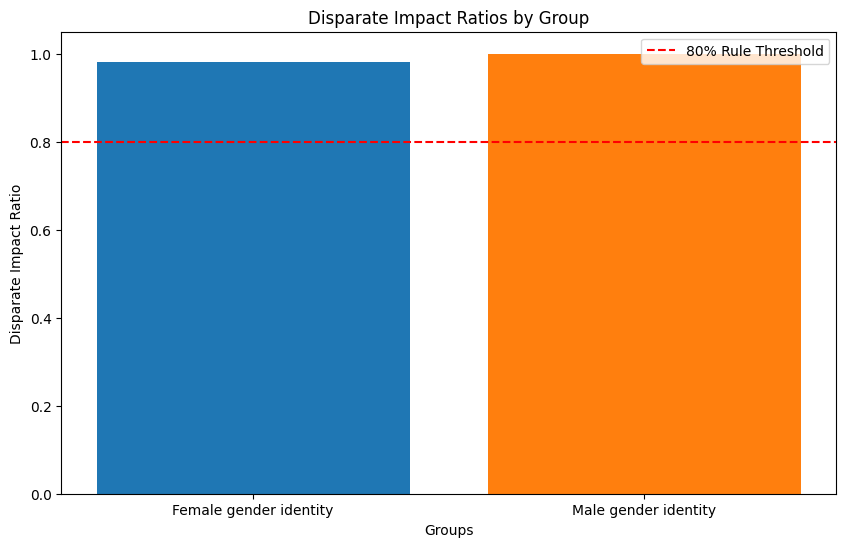

---GENDER---
Chi-Square Statistic: 0.0, p-value: 1.0
Disparate Impact Ratio for Group Female gender identity: 0.9820288716488265
Disparate Impact Ratio for Group Male gender identity: 1.0


--- GENDER ---
    tp   fp     tn     fn  sens    spec  ppv     npv       j   f1       mcc  \
0  0.0  4.0  721.0  134.0   0.0  0.9945  0.0  0.8433 -0.0055  0.0 -0.029406   

    brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.1607  0.0  0.0      134.0        4.0     -130.0        -0.9701  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0045  0.0
   1.0 0.0060  0.0

And loss is 0.1607


Post-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0045  0.0
   1.0 0.0040  0.0

And loss is 0.1595

Equal Opportunity

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0045  0.0
   1.0 0.0060  0.0

And loss is 0.1607


Post-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0045  0.0
   1.0 0.0060  0.0

And loss is 0.1607




In [19]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='gender')
print()

#### Age fairness

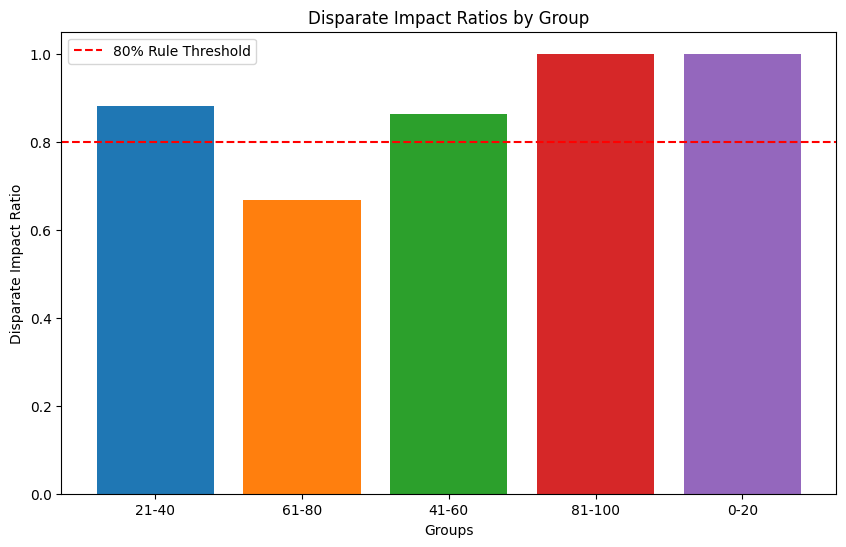

---AGE---
Chi-Square Statistic: 7.22583004743128, p-value: 0.12442464089529531
Disparate Impact Ratio for Group 21-40: 0.8809523809523809
Disparate Impact Ratio for Group 61-80: 0.6683417085427136
Disparate Impact Ratio for Group 41-60: 0.8631921824104235
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 0-20: 1.0


--- AGE_BIN ---
    tp   fp     tn     fn  sens    spec  ppv     npv       j   f1       mcc  \
0  0.0  4.0  721.0  134.0   0.0  0.9945  0.0  0.8433 -0.0055  0.0 -0.029406   

    brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.1607  0.0  0.0      134.0        4.0     -130.0        -0.9701  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0000  NaN
   1.0 0.0000  0.0
   2.0 0.0149  0.0
   3.0 0.0000  0.0
   4.0 0.0000  NaN

And loss is 0.1607


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  0.0
   3.0  0.0  0.0
   4.0  0.0  NaN

And loss is 0.15

In [20]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='age')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='AGE_bin')
print()

#### Site fairness

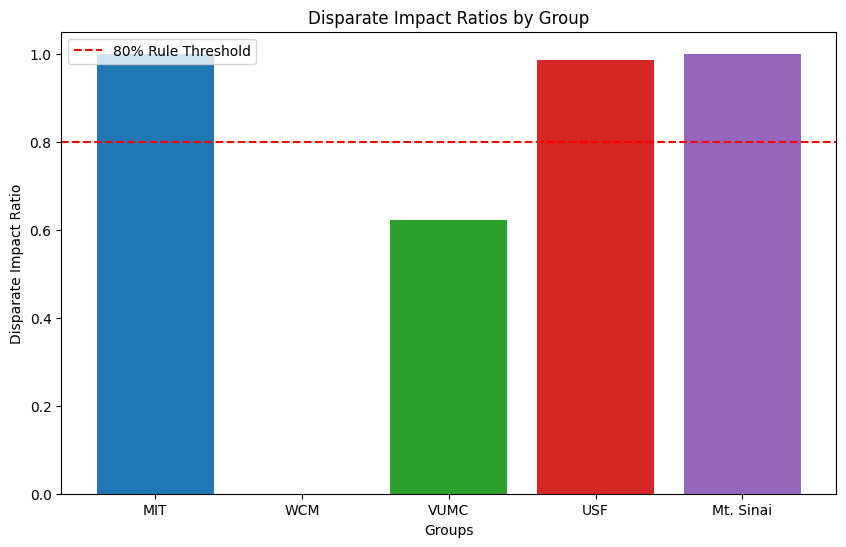

---SITE---
Chi-Square Statistic: 8.354314699532585, p-value: 0.07942824700195647
Disparate Impact Ratio for Group MIT: 1.0
Disparate Impact Ratio for Group WCM: 0.0
Disparate Impact Ratio for Group VUMC: 0.6230769230769231
Disparate Impact Ratio for Group USF: 0.985663082437276
Disparate Impact Ratio for Group Mt. Sinai: 1.0


--- SITE ---
    tp   fp     tn     fn  sens    spec  ppv     npv       j   f1       mcc  \
0  0.0  4.0  721.0  134.0   0.0  0.9945  0.0  0.8433 -0.0055  0.0 -0.029406   

    brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.1607  0.0  0.0      134.0        4.0     -130.0        -0.9701  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0000  NaN
   1.0 0.0000  0.0
   2.0 0.0000  NaN
   3.0 0.0143  NaN
   4.0    NaN  0.0

And loss is 0.1607


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  NaN
   3.0  0.0  NaN
   4.0  NaN  0.0

And loss is 0.1560

Equal Opportunit

In [21]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='site')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='site')
print()

### Histogram Comparison (IGNORE)

In [22]:

# def hist_comp(attribute='gender'):
#     sensitive_attribute = opensmile_df_test[attribute]
    
#     # Define the unique values in your sensitive attribute
#     unique_groups = sensitive_attribute.unique()
    
#     # Plot histograms for each group
#     plt.figure(figsize=(12, 8))
    
#     colors = plt.get_cmap('tab10').colors
    
#     for i, group in enumerate(unique_groups):
#         group_predictions = predictions[sensitive_attribute == group]
#         group_truth = y_test[sensitive_attribute == group]

#         if attribute == 'gender':
#             map_func = DT_test_dataset.map_gender_back
#         elif attribute == 'site':
#             map_func = DT_test_dataset.map_site_back
        
#         plt.hist(group_predictions, alpha=0.5, label=map_func(group), bins=5, color=colors[i % len(colors)])
#         plt.hist(group_truth, alpha=0.5, label=f'Ground Truth {map_func(group)}', bins=5, histtype='step', 
#                  linestyle='--', color=colors[i % len(colors)])
    
#     plt.legend(loc='upper right')
#     plt.xlabel('Predicted Values')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Predictions by ' + attribute)
#     plt.show()


# hist_comp('gender')


### Model explainer using SHAP (IGNORE)

In [23]:
# # https://www.sciencedirect.com/science/article/pii/S0169260721006581#fig0003
# # https://datascientest.com/en/shap-what-is-it
# # https://shap.readthedocs.io/en/latest/
# #https://github.com/shap/shap#citations

# import shap

# explainer = shap.TreeExplainer(RF_clf)
# shap_values = explainer.shap_values(X_test)

# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test, feature_names=feature_columns)
# #shap.force_plot(shap_values, X_test)

## Just Visualization into lower dimension no classifier

### PCA

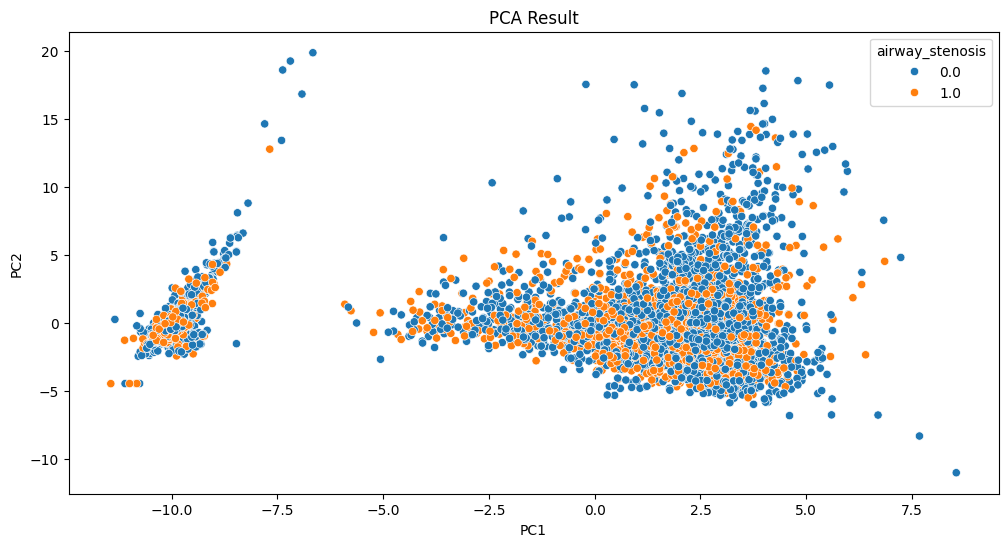

In [24]:

#target_diagnosis = 'voc_fold_paralysis' #airway_stenosis
target_diagnosis = 'airway_stenosis'

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs,diagnosis_column=target_diagnosis)
opensmile_df, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS=False,
                                                                    diagnosis_column=target_diagnosis)

# Perform PCA
pca = PCA(n_components=3)
scalar = StandardScaler()
scaled_features = scalar.fit_transform(opensmile_df[feature_columns])

pca_result = pca.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:2], columns=['PC1', 'PC2'])
#pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)
pca_df = pd.concat([pca_df, opensmile_df[label_columns].reset_index(drop=True)], axis=1)

plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue=target_diagnosis, data=pca_df)
plt.title('PCA Result')
plt.show()


In [25]:

target_diagnosis = 'voc_fold_paralysis' #airway_stenosis
#target_diagnosis = 'airway_stenosis'

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs,diagnosis_column=target_diagnosis)
opensmile_df, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS=False,
                                                                    diagnosis_column=target_diagnosis)

# Perform PCA
pca = PCA(n_components=3)
scalar = StandardScaler()
scaled_features = scalar.fit_transform(opensmile_df[feature_columns])

pca_result = pca.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:2], columns=['PC1', 'PC2'])
#pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)
pca_df = pd.concat([pca_df, opensmile_df[label_columns].reset_index(drop=True)], axis=1)


#print(opensmile_df[label_columns])

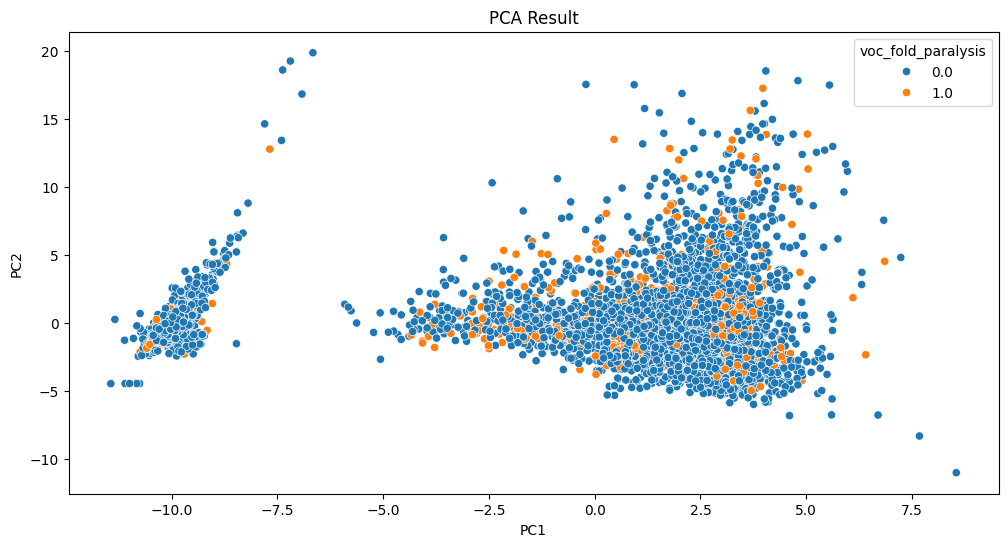

In [26]:

plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue=target_diagnosis, data=pca_df)
plt.title('PCA Result')
plt.show()

#print(sns.color_palette())

##### PCA 2D scatter plot colored by gender

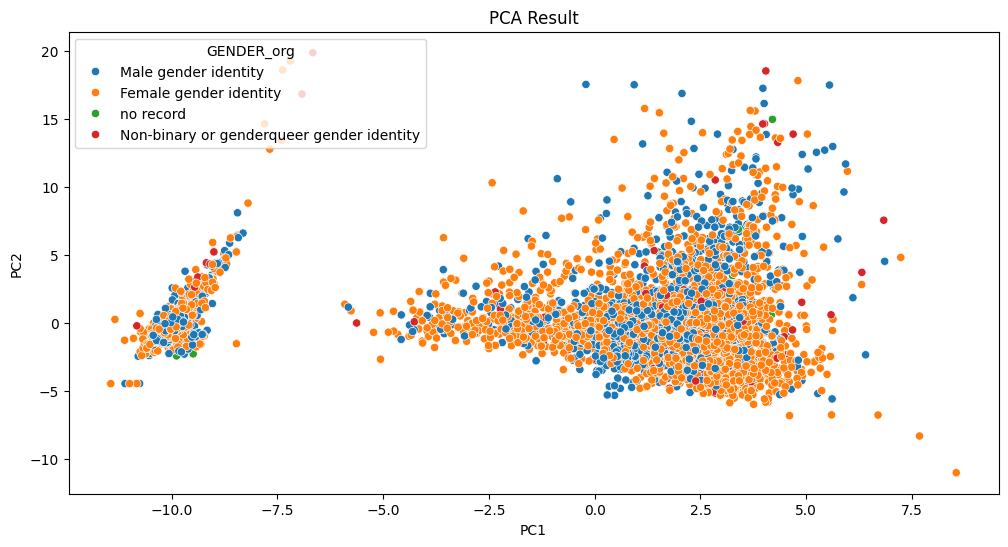

In [27]:

plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='GENDER_org', data=pca_df)
plt.title('PCA Result')
plt.show()

#print(sns.color_palette())

##### PCA 2D scatter plot colored by age

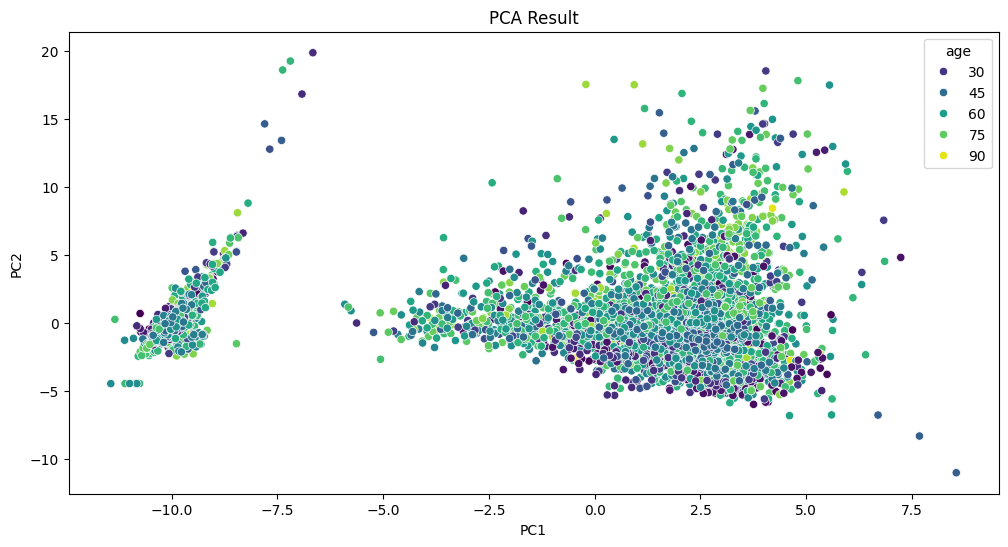

In [28]:
# Plot PCA result
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='age', data=pca_df, palette='viridis') #coolwarm, plasma, viridis
plt.title('PCA Result')
plt.show()

##### PCA 2D scatter plot colored by age-bins

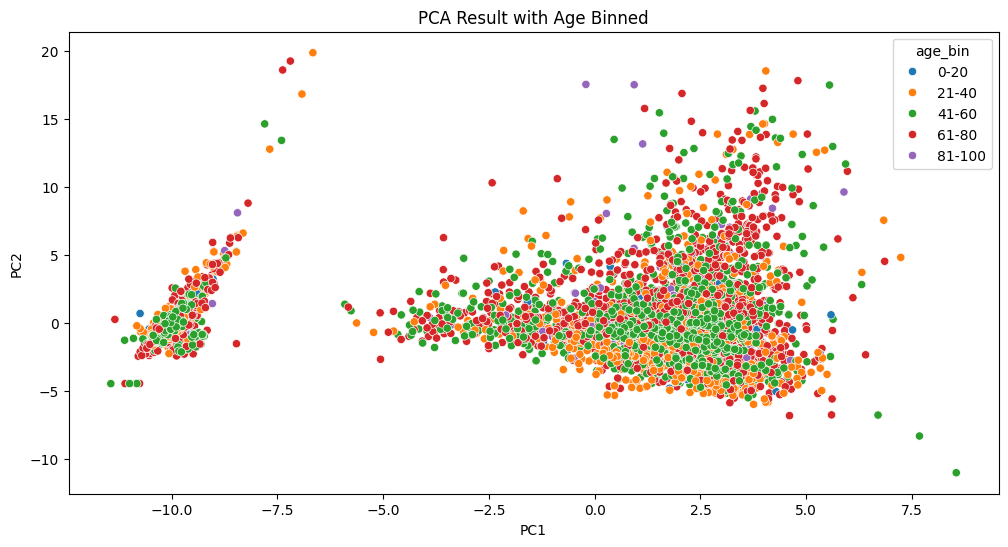

In [29]:

# Define age bins
bins = [0, 20, 40, 60, 80, 100]  # Define bins for age ranges
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']  # Define bin labels
pca_df['age_bin'] = pd.cut(pca_df['age'], bins=bins, labels=labels)

# Plot PCA result with discrete age bins
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='age_bin', data=pca_df)
plt.title('PCA Result with Age Binned')
plt.show()


##### PCA 3D scatter plot colored by gender

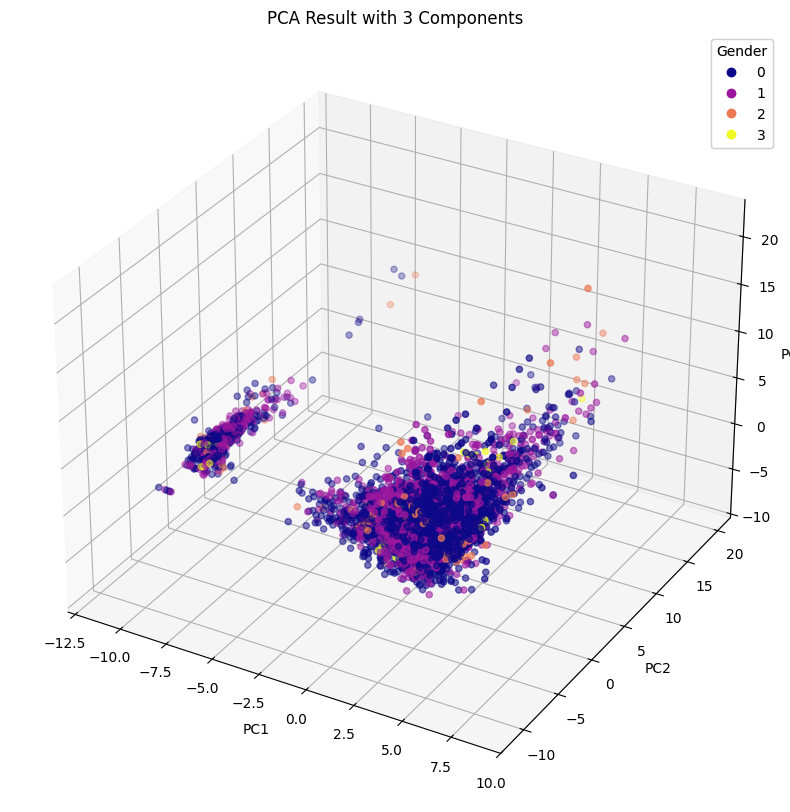

In [30]:

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:3], columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
#coolwarm, plasma, viridis
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['GENDER_org'].astype('category').cat.codes, cmap='plasma')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Gender")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()



##### PCA 3D scatter plot colored by age

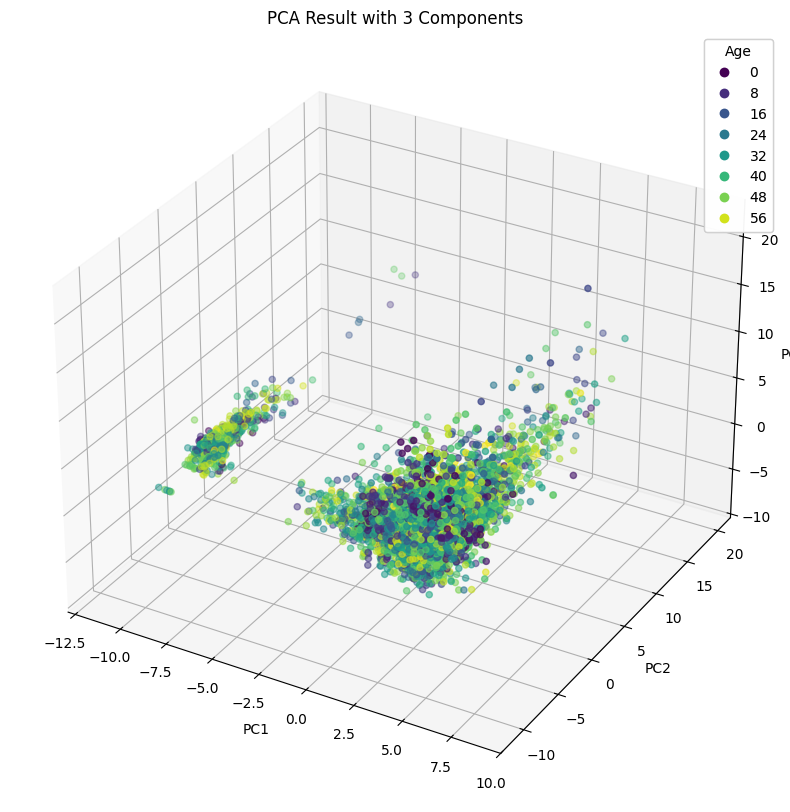

In [31]:

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()

#### t-SNE

In [32]:
# Perform t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_features)

#prepare t-SNE result for 2D scatter plot
tsne_df = pd.DataFrame(tsne_result[:,:2], columns=['TSNE1', 'TSNE2'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)


##### t-SNE 2D scatter plot colored by gender

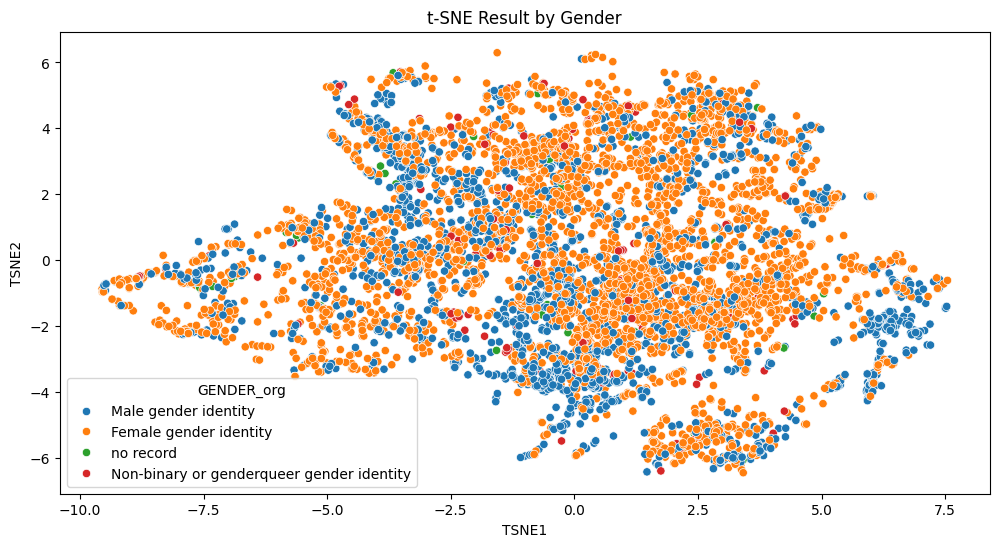

In [33]:
# Plot t-SNE result
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='GENDER_org', data=tsne_df)
plt.title('t-SNE Result by Gender')
plt.show()

##### t-SNE 2D scatter plot colored by age-bins

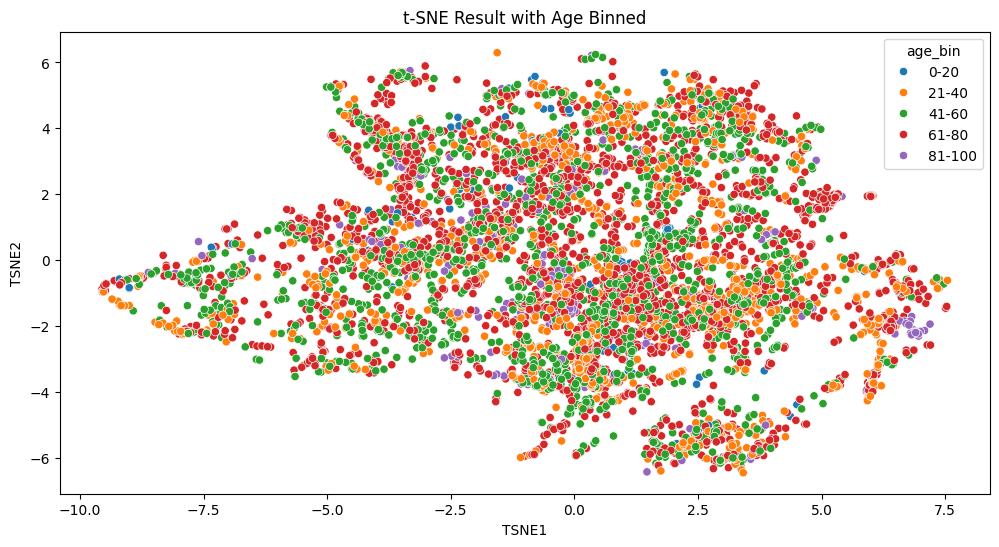

In [34]:

# Define age bins
bins = [0, 20, 40, 60, 80, 100]  # Define bins for age ranges
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']  # Define bin labels
tsne_df['age_bin'] = pd.cut(tsne_df['age'], bins=bins, labels=labels)

# Plot PCA result with discrete age bins
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='age_bin', data=tsne_df,) #coolwarm, plasma, viridis
plt.title('t-SNE Result with Age Binned')
plt.show()


##### t-SNE 2D scatter plot colored by site

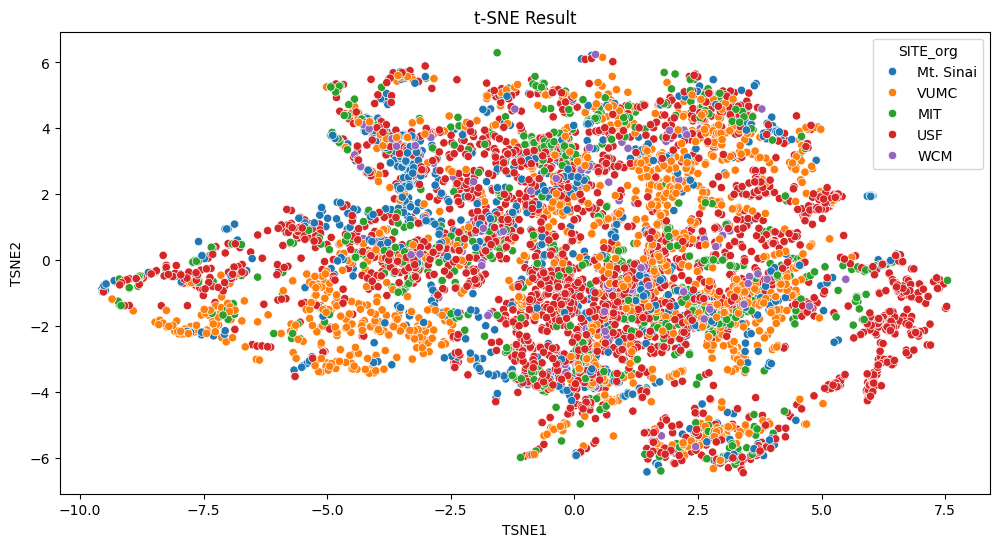

In [35]:
# Plot t-SNE result
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='SITE_org', data=tsne_df)
plt.title('t-SNE Result')
plt.show()

##### t-SNE 3D scatter plot colored by age

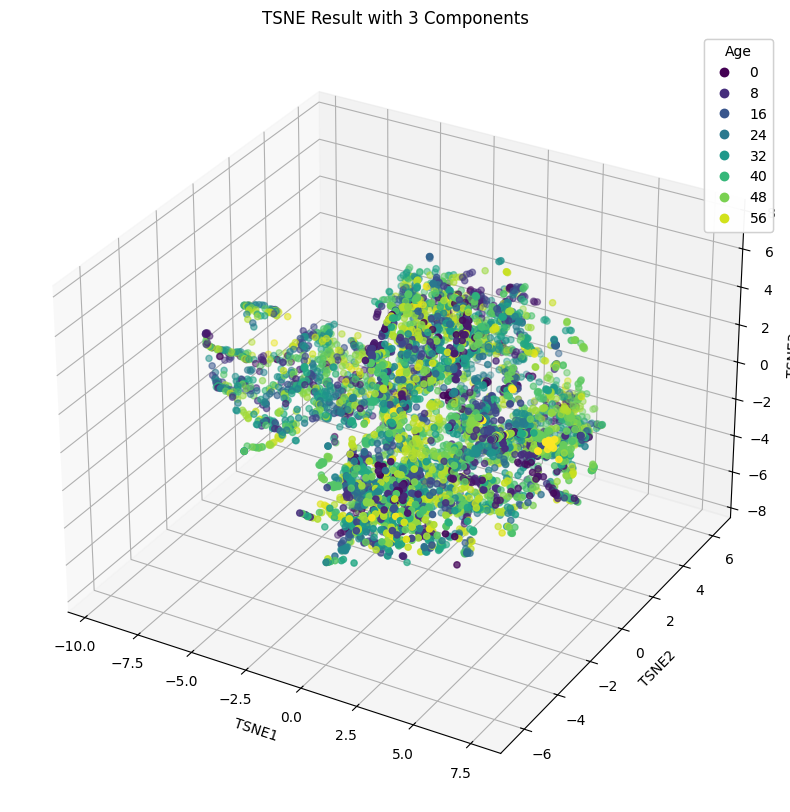

In [36]:

#prepare the data for plotting 2D scatter plot of PCA features
tsne_df = pd.DataFrame(tsne_result[:,:3], columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

#Plot TSNE 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], c=tsne_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('TSNE Result with 3 Components')
plt.show()

#### Correlation heatmap

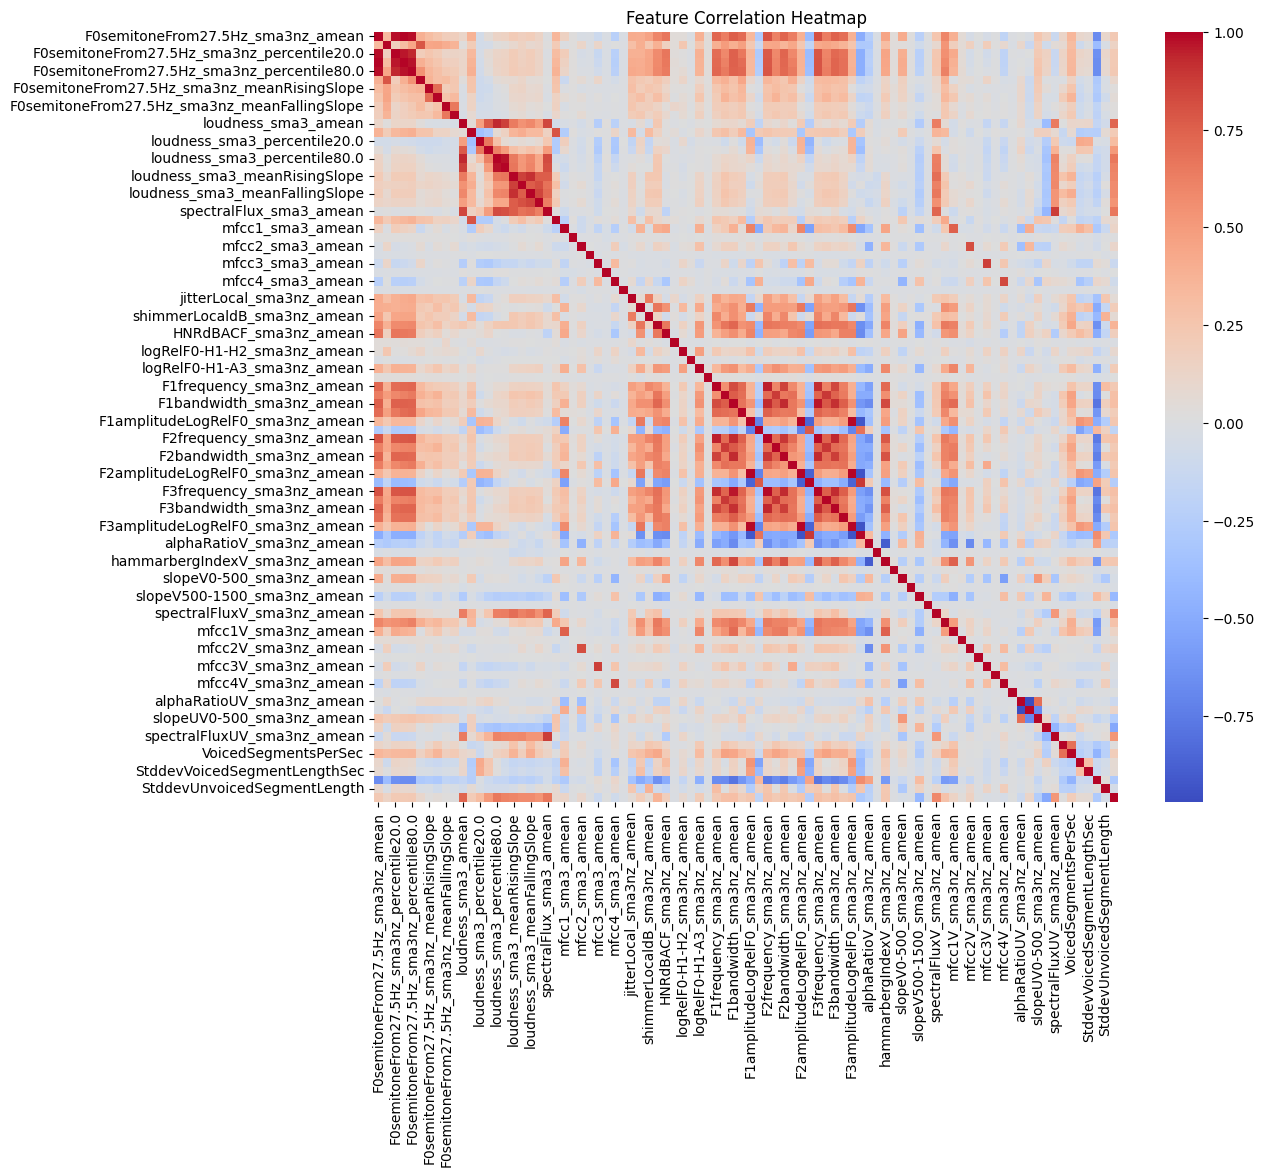

In [37]:
# Correlation Heatmap
corr_matrix = pd.DataFrame(scaled_features, columns=feature_columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Scree plot PCA

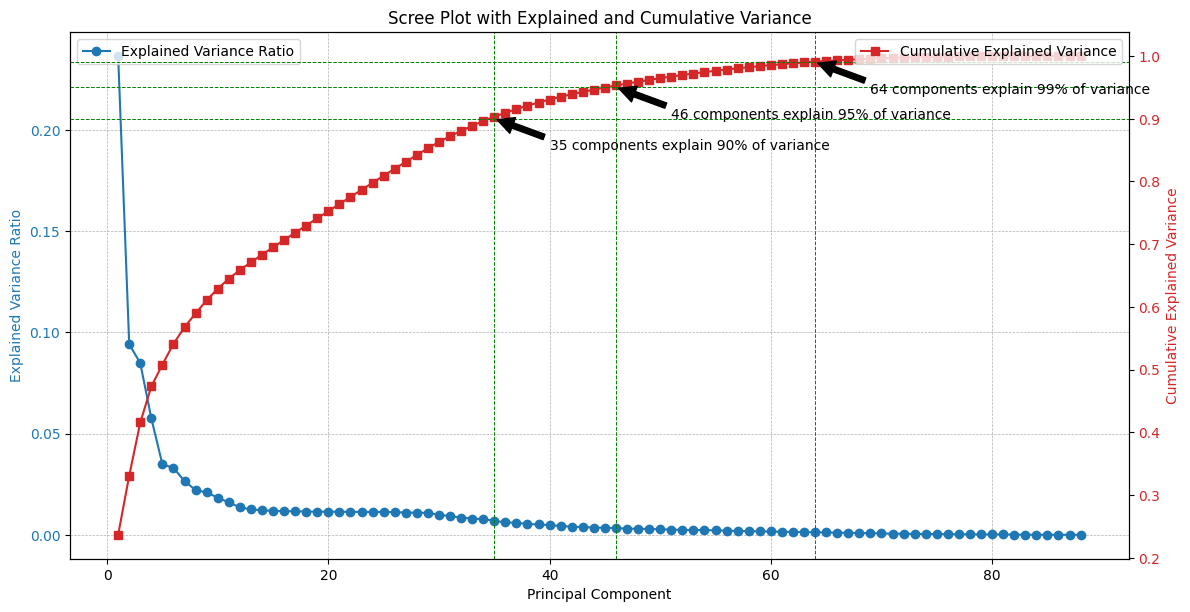

In [38]:

'''
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.
'''

# Perform PCA
pca_full = PCA(n_components=88)
pca_result = pca_full.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
#pca_df = pd.DataFrame(pca_result)
#pca_df = pd.concat([pca_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)

variance_ratio= pca_full.explained_variance_ratio_

# Prepare data for plotting
x = np.arange(1, len(variance_ratio) + 1)
y = variance_ratio

# Cumulative explained variance
cumulative_variance = np.cumsum(variance_ratio)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot explained variance
color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.plot(x, y, 'o-', color=color, label='Explained Variance Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot cumulative explained variance
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Cumulative Explained Variance', color=color)
ax2.plot(x, cumulative_variance, 's-', color=color, label='Cumulative Explained Variance')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.tight_layout()  # To ensure the right y-label is not slightly clipped
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adding titles and labels
plt.title('Scree Plot with Explained and Cumulative Variance')
plt.xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Variance')

# Annotate the point where 95% of variance is explained
# Annotate the point where 90%, 95%, and 99% of variance is explained
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components_to_threshold = np.argmax(cumulative_variance >= threshold) + 1
    ax2.axhline(y=threshold, color='g', linestyle='--', linewidth=0.7)
    ax2.axvline(x=num_components_to_threshold, color='g', linestyle='--', linewidth=0.7)
    ax2.annotate(f'{num_components_to_threshold} components explain {threshold * 100:.0f}% of variance',
                 xy=(num_components_to_threshold, threshold), xytext=(num_components_to_threshold + 5, threshold - 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))


# Show the plot
plt.show()

In [39]:
def calc_min_principle_comp_required(variance_ratio, variance_ratio_threshold):
  
  maintained_variance_ratio = 0.0
  n = 1

  while maintained_variance_ratio < variance_ratio_threshold:

    maintained_variance_ratio = sum(variance_ratio[:n])
    n+=1

  return n-1

In [40]:
principal_component_count_90 = calc_min_principle_comp_required(variance_ratio, 0.90)

print(principal_component_count_90)

35


In [41]:
principal_component_count_95 = calc_min_principle_comp_required(variance_ratio, 0.95)

print(principal_component_count_95)

46


In [42]:
principal_component_count_99 = calc_min_principle_comp_required(variance_ratio, 0.99)

print(principal_component_count_99)

64


#### Scree plot t-SNE

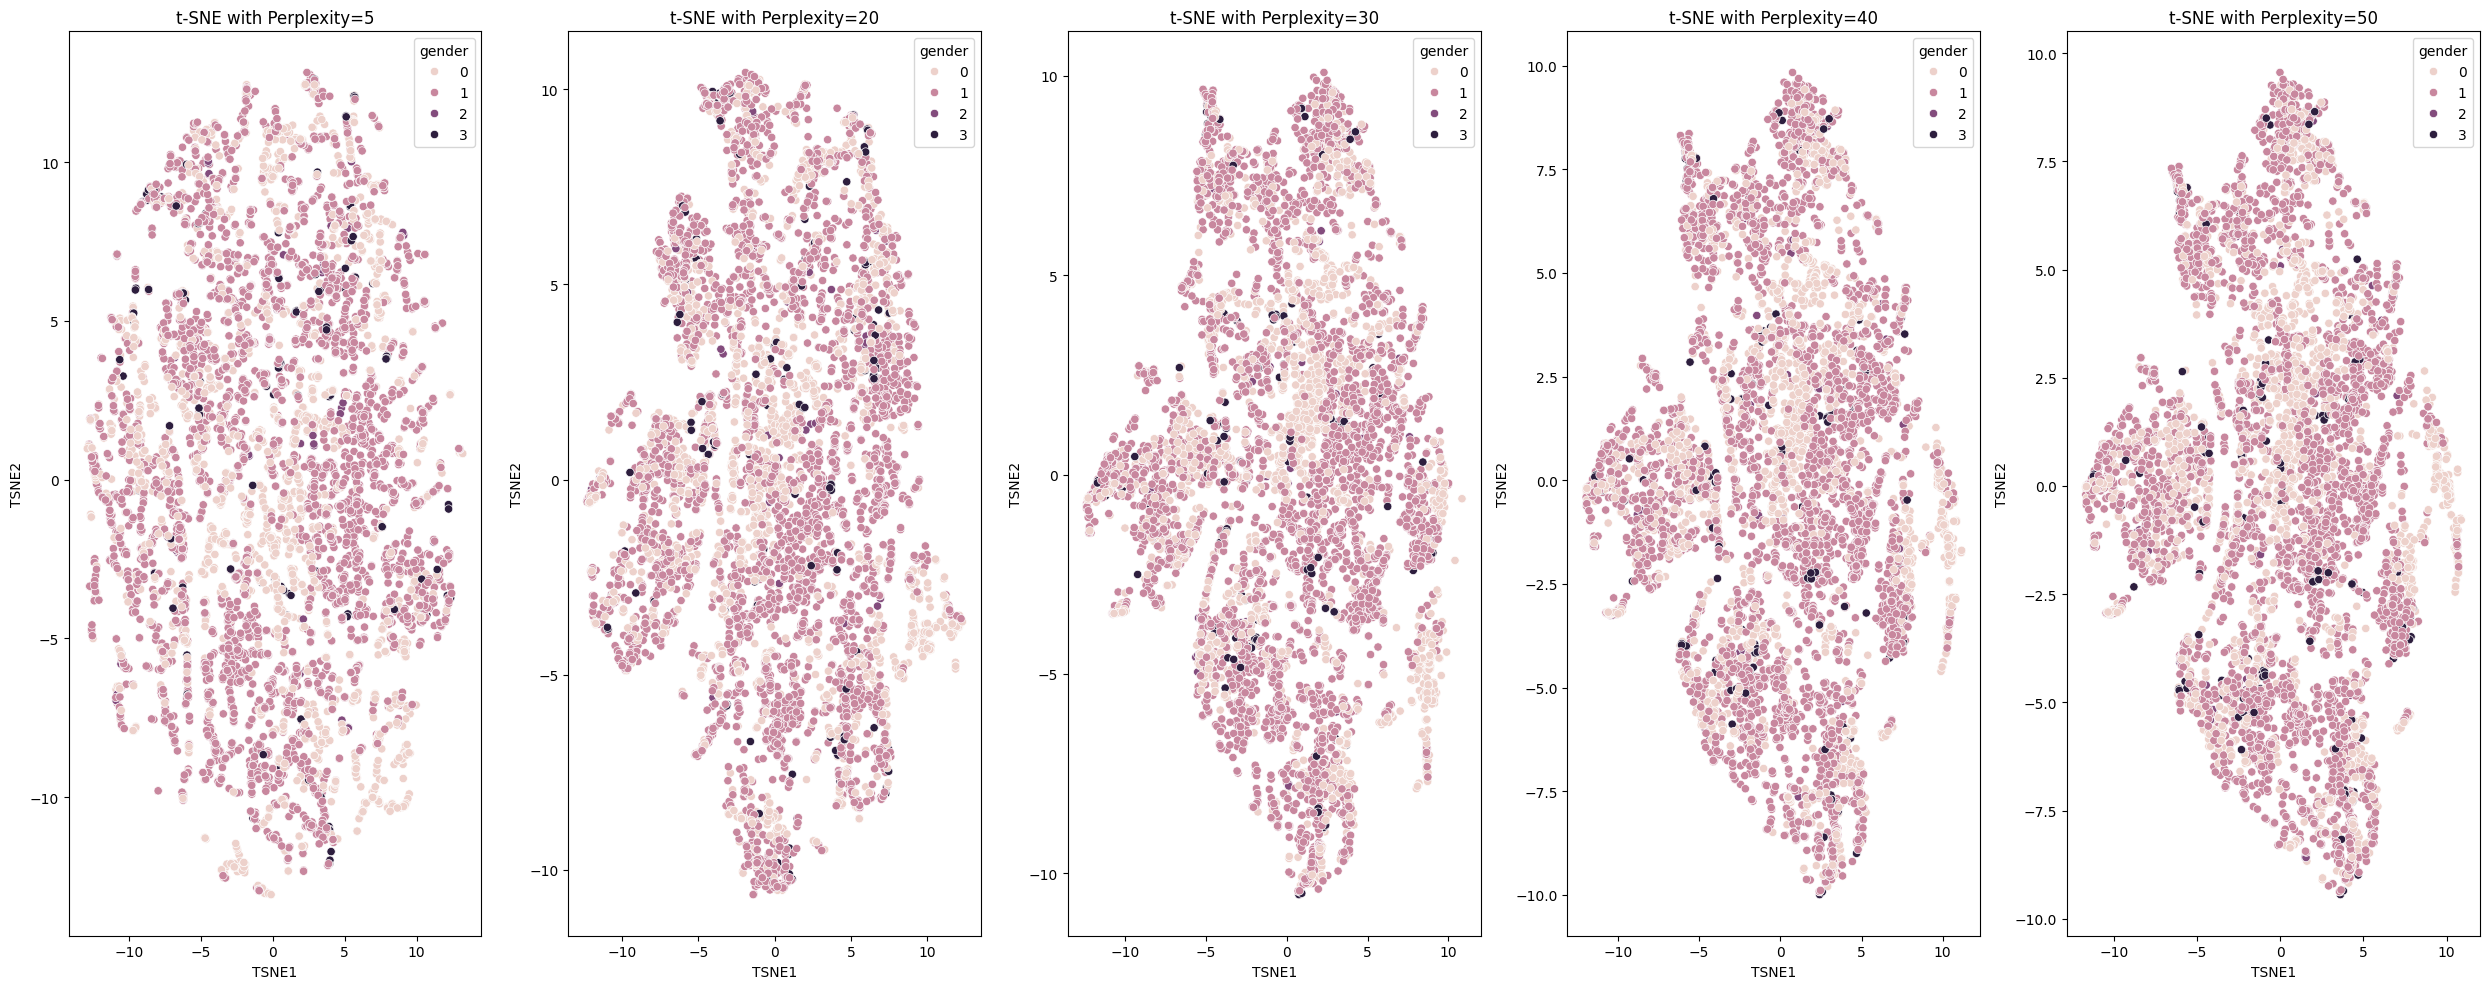

In [43]:

# Define perplexity values
perplexities = [5, 20, 30, 40, 50]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 10))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300)
    tsne_result = tsne.fit_transform(scaled_features)
    
    # Create DataFrame for plotting
    #tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)
    tsne_df['perplexity'] = perplexity
    
    # Plot
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, ax=axes[i])
    #sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df, ax=axes[i])
    axes[i].set_title(f't-SNE with Perplexity={perplexity}')
    axes[i].set_xlabel('TSNE1')
    axes[i].set_ylabel('TSNE2')

plt.tight_layout()
plt.show()


# Test cells (ignore those)

In [44]:

x = torch.load('./data/bids_with_sensitive_recordings/sub-0ee1e1e1-0e86-42cc-9e9d-2cafd9f1e01c/ses-CC0EE711-2FC3-43D5-B7FF-21424F748985/audio/sub-0ee1e1e1-0e86-42cc-9e9d-2cafd9f1e01c_ses-CC0EE711-2FC3-43D5-B7FF-21424F748985_Diadochokinesis_rec-Diadochokinesis-Pataka.pt')

x.keys()

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])

In [45]:
print(type(x['opensmile']['equivalentSoundLevel_dBp']))
print(type(x['opensmile']))
print(x['opensmile']['equivalentSoundLevel_dBp'].shape)
print(x['opensmile'].shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
(1,)
(1, 88)


In [46]:
print(len(list(x['opensmile'].columns)))

88


In [47]:
for ftr in x['opensmile']:
    print(type(x['opensmile'][ftr]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

In [48]:
print(x['opensmile'].shape, type(x['opensmile']))
for ftr in x['opensmile']:
    print(type(ftr), ftr)

(1, 88) <class 'pandas.core.frame.DataFrame'>
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_amean
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_stddevNorm
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_percentile20.0
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_percentile50.0
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_percentile80.0
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
<class 'str'> F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope
<class 'str'> loudness_sma3_amean
<class 'str'> loudness_sma3_stddevNorm
<class 'str'> loudness_sma3_percentile20.0
<class 'str'> loudness_sma3_percentile50.0
<class 'str'> loudness_sma3_percentile80.0
<class 'str'> loudness_sma3_pctlrange0-2
<class 'str'> loudness_sma3_meanRisingSlope
<class 'str'> loudness_sma3_stddevRisingSlope
<class 'str'> loudness_sma3_meanFallingSlope
<class 'str

In [49]:
qs = dataset_sample.load_questionnaires('recordingschema')

print(len(qs))
#print(qs[0].json(indent=2))

NameError: name 'dataset_sample' is not defined

In [ ]:
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema')
print(demographics_df.shape)
#print(demographics_df.columns)
demographics_df_uniq = demographics_df.drop_duplicates(subset='record_id', keep='first')
print(demographics_df_uniq.shape)

#print("Duplicates : ", demographics_df[demographics_df.duplicated(subset='record_id')]['record_id'].to_list())

participant_df = dataset.load_and_pivot_questionnaire('participant')

ids_in_participant_not_demographic = participant_df.set_index('record_id').index.difference(demographics_df_uniq.set_index('record_id').index)

#print(ids_in_participant_not_demographic.to_list())

#duplicate_demographics_record = ['01401050-e9dd-486e-b0d4-0001ee7f861d', 'd554cc1a-efe5-4b7a-a77b-f5abca8846bd', '771fb46d-e94a-4129-ab3d-32cadf92c6f0']
#no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']

#df = pd.read_csv('/home/mithrandir/Documents/Summer school/data/demographics.csv')

#print(df.shape)
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')[['record_id', 'gender_identity']]
print(demographics_df.shape)
row1 = {'record_id': no_demographics_record[0], 'gender_identity': 'no record'}
row1 = {'record_id': no_demographics_record[1], 'gender_identity': 'no record'}

new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})

demographics_df = pd.concat([demographics_df,new_row_df], ignore_index=True).sort_values(by='record_id').to_numpy()
print(demographics_df.shape)
